In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
import statistics

## Helper functions!

In [2]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [17]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

columns_to_scale = ['ATMs', 'Shops']

scaler = StandardScaler().fit(X[columns_to_scale]) 

X[columns_to_scale] = scaler.transform(X[columns_to_scale])
X_new = X.copy()

X_new['Downtown_NotWeekday_Center'] = X_new['Downtown'] * (1 - X_new['Weekday'] ) * X_new['Center']
X_new["Shops_DWC"] = X_new['Downtown_NotWeekday_Center'] * X_new['Shops'] 
X_new["ATMs_DWC"] = X_new['Downtown_NotWeekday_Center'] * X_new['ATMs'] 

X_new = X_new.drop(columns=['Downtown']).mul(X_new['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  
X = pd.merge(left = X, right = X_new, left_index=True, right_index=True)

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High', 'Shops_DT',
       'ATMs_DT', 'Weekday__DT', 'Center_DT', 'High_DT',
       'Downtown_NotWeekday_Center', 'Shops_DWC', 'ATMs_DWC'],
      dtype='object')

In [38]:
scaled_data = pd.merge(X,y,left_index=True,right_index=True)
scaled_data

,Shops,ATMs,Downtown,Weekday,Center,High,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,ATMs_DWC,Withdraw
0,0.695292,0.561492,1,0,0,0,0.695292,0.561492,0,0,0,0,0.0,0.0,72.750556
1,0.588459,0.561492,1,1,0,0,0.588459,0.561492,1,0,0,0,0.0,0.0,66.720482
2,-1.543334,-1.616368,0,0,0,1,-0.000000,-0.000000,0,0,0,0,-0.0,-0.0,19.189516
3,0.549611,0.289259,1,1,0,1,0.549611,0.289259,1,0,1,0,0.0,0.0,67.388669
4,-1.526338,-1.071903,0,1,0,1,-0.000000,-0.000000,0,0,0,0,-0.0,-0.0,15.813127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21995,0.688007,1.105957,1,0,0,0,0.688007,1.105957,0,0,0,0,0.0,0.0,71.384290
21996,-1.531194,-1.616368,0,1,0,0,-0.000000,-0.000000,0,0,0,0,-0.0,-0.0,16.031066
21997,-1.543334,-1.344135,0,1,0,0,-0.000000,-0.000000,0,0,0,0,-0.0,-0.0,14.968847
21998,0.629735,-0.527438,1,0,0,0,0.629735,-0.527438,0,0,0,0,0.0,-0.0,73.705665


In [27]:
# 1. Separate
X_train, X_test, y_train, y_test = train_test_split(
    X,              # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=1      # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)

train.head()

,Withdraw,Shops,ATMs,Downtown,Weekday,Center,High,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,ATMs_DWC
7214,71.451101,0.629735,0.833724,1,1,1,1,0.629735,0.833724,1,1,1,0,0.0,0.0
13522,64.949936,0.537471,0.289259,1,1,0,0,0.537471,0.289259,1,0,0,0,0.0,0.0
18479,70.265111,0.641875,0.017027,1,1,0,1,0.641875,0.017027,1,0,1,0,0.0,0.0
3366,70.693183,0.658871,0.561492,1,1,0,1,0.658871,0.561492,1,0,1,0,0.0,0.0
21645,16.757929,-1.502058,-1.344135,0,1,0,0,-0.000000,-0.000000,0,0,0,0,-0.0,-0.0


In [28]:
# 3. Model
formula = f'Withdraw ~ {" + ".join(X_train.columns)}'  

model = ols(formula, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  0.26952574471388413
Train MSE:  0.2714183998650767


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.903e+06
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:30:54   Log-Likelihood:                -13497.
No. Observations:               17600   AIC:                         2.702e+04
Df Residuals:                   17585   BIC:                         2.714e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     24.4639      0.902     27.135      0.000      22.697      26.231
Shops                          7.6321      0.587     12.998      0.000       6.481       8.783
ATMs                          -3.6403      0.026   -141.854      0.000      -3.691      -3.590
Downtown                      19.1051      0.904     21.138      0.000      17.334      20.877
Weekday                       -2.2179      0.016   -140.097      0.000      -2.249      -2.187
Center                         3.5909      0.024    150.685      0.000       3.544       3.638
High                           1.0376      0.016     65.919      0.000       1.007       1.068
Shops_DT                      37.6878      0.595     63.332      0.000      36.521      38.854
ATMs_DT                       -0.0388      0.027     -1.433      0.152      -0.092       0.014
Weekday__DT                    0.2242      0.019     11.631      0.000       0.186       0.262
Center_DT                     -0.5763      0.030    -19.130      0.000      -0.635      -0.517
High_DT                       -0.0506      0.019     -2.696      0.007      -0.087      -0.014
Downtown_NotWeekday_Center    13.9044      0.369     37.683      0.000      13.181      14.628
Shops_DWC                      9.3022      0.561     16.595      0.000       8.203      10.401
ATMs_DWC                      -0.0010      0.050     -0.020      0.984      -0.100       0.098
==============================================================================
Omnibus:                       65.192   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.188
Skew:                           0.113   Prob(JB):                     3.48e-16
Kurtosis:                       3.214   Cond. No.                         723.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note: the MSE is already lower!

Looking at the p values, we should exclude variables `ATMs_DT` and `High_DT` from the model.


## Best Subset selection!

AIC, BIC, test MSE all used. An interesting feature might be to change the train test split.

In [29]:
# Initialize lists to store metrics
aic = []
bic = []
p = []
test_mse = []

# Start time measurement
start_time = time.time()

count = 1

# Null model with just the intercept
formula = 'Withdraw ~ 1'
model = ols(formula, data=train).fit()
aic.append(model.aic)
bic.append(model.bic)
test_mse.append(comp_mse(model, test))
p.append(1)

# Initialize best metrics with the null model
best_aic = model.aic
best_bic = model.bic
best_model_aic = formula
best_model_bic = formula
best_p_aic = 1
best_p_bic = 1
best_test_mse = test_mse[-1]
best_model_test_mse = formula

# Iterate over all combinations of predictors
for i in range(1, len(X_train.columns) + 1):

    # Reintialise best_train_mse for each i
    best_train_mse = np.inf 

    for combo in itertools.combinations(X_train.columns, i):
        # Create the model formula
        formula = f'Withdraw ~ {" + ".join(combo)}'
        model = ols(formula, data=train).fit()
        train_mse = comp_mse(model, train)

        # Store the AIC, BIC, and number of parameters using append
        aic.append(model.aic)
        bic.append(model.bic)
        p.append(i + 1)
        
        # Update best AIC model if current model is better
        if model.aic < best_aic:
            best_model_aic = formula
            best_aic = model.aic
            best_p_aic = i + 1 
        
        # Update best BIC model if current model is better
        if model.bic < best_bic:
            best_model_bic = formula
            best_bic = model.bic
            best_p_bic = i + 1 

        count += 1

        #use train MSE to select the best set for a given number of predictors i
        if train_mse < best_train_mse:
            best_model_train_mse = formula
            best_model_fit_train_mse = model
            best_train_mse = train_mse

    # once the best set was found for given i compute test mse
    test_mse.append(comp_mse(best_model_fit_train_mse, test))

    # Update best model based on test_mse if current model is better
    if test_mse[-1] < best_test_mse:
        best_model_test_mse = best_model_train_mse
        best_test_mse = test_mse[-1]
        best_p_test = i + 1

    end_time = time.time()
    elapsed_time = end_time - start_time

# Output the best model
print(f"Best subset selection took {count} iterations and {elapsed_time:.2f} seconds. Best model based on each statistic is as follows (includes intercept):")
print(f"AIC={best_aic:.2f} with {best_p_aic} parameters:\n {best_model_aic}\n")
print(f"BIC={best_bic:.2f} with {best_p_bic} parameters:\n {best_model_bic}\n") 
print(f"test MSE: {best_test_mse:.2f} has {best_p_test} parameters:\n {best_model_test_mse}")

Best subset selection took 16384 iterations and 198.16 seconds. Best model based on each statistic is as follows (includes intercept):
AIC=27022.59 with 14 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Downtown_NotWeekday_Center + Shops_DWC

BIC=27121.12 with 12 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops_DWC

test MSE: 0.27 has 12 parameters:
 Withdraw ~ Shops + ATMs + Downtown + Weekday + Center + High + Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops_DWC


<Axes: >

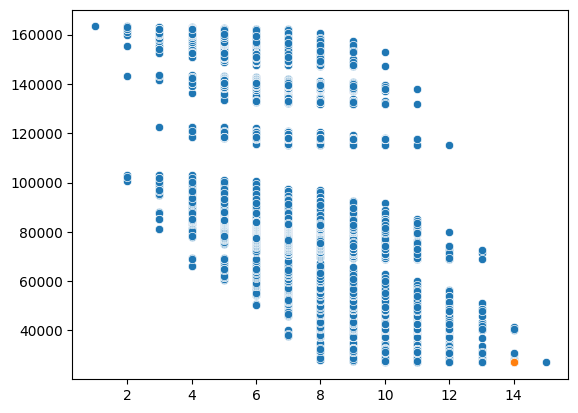

In [31]:
sns.scatterplot(x=p, y=aic)
sns.scatterplot(x=[best_p_aic], y=[best_aic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

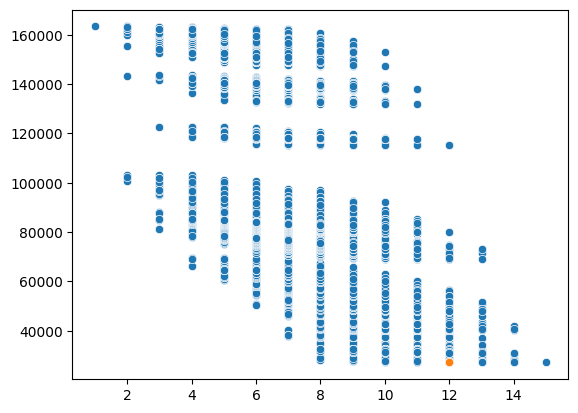

In [32]:
sns.scatterplot(x=p, y=bic)
sns.scatterplot(x=[best_p_bic], y=[best_bic]) # note here we plot just one point, but we need to pass is as list, hence the []

<Axes: >

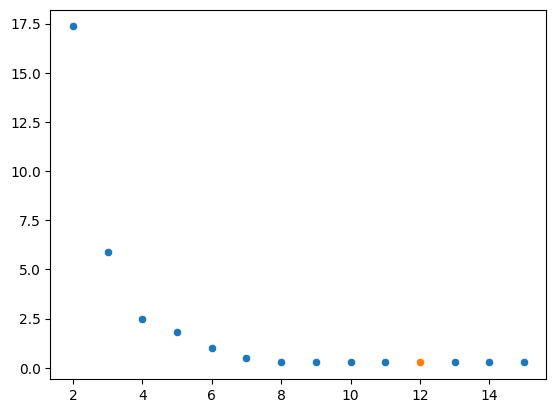

In [33]:
sns.scatterplot(x=range(1+1, len(train.columns) + 1),y=test_mse[1:])
sns.scatterplot(x=[best_p_test], y=[best_test_mse]) # note here we plot just one point, but we need to pass is as list, hence the []

In [34]:
# 3. AIC Best Model
# formula = "Withdraw ~ Shops_DT + ATMs_DT + Weekday__DT + Center_DT + High_DT + Downtown_NotWeekday_Center + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"

model = ols(best_model_aic, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Test MSE:  0.26952662067474065
Train MSE:  0.2714184057389417


In [35]:
# BIC Best Model
# Train MSE Best Model
# formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"

model = ols(best_model_bic, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
model.summary()

Test MSE:  0.2690572201362614
Train MSE:  0.27156077932681455


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.694e+06
Date:                Thu, 31 Oct 2024   Prob (F-statistic):               0.00
Time:                        12:34:51   Log-Likelihood:                -13502.
No. Observations:               17600   AIC:                         2.703e+04
Df Residuals:                   17588   BIC:                         2.712e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     24.4040      0.901     27.089      0.000      22.638      26.170
Shops                          7.6167      0.587     12.970      0.000       6.466       8.768
ATMs                          -3.6752      0.008   -455.015      0.000      -3.691      -3.659
Downtown                      19.1581      0.903     21.211      0.000      17.388      20.928
Weekday                       -2.2178      0.016   -140.082      0.000      -2.249      -2.187
Center                         3.5912      0.024    150.676      0.000       3.545       3.638
High                           1.0019      0.009    116.831      0.000       0.985       1.019
Shops_DT                      37.7034      0.595     63.350      0.000      36.537      38.870
Weekday__DT                    0.2244      0.019     11.636      0.000       0.187       0.262
Center_DT                     -0.5770      0.030    -19.153      0.000      -0.636      -0.518
Downtown_NotWeekday_Center    13.9064      0.367     37.933      0.000      13.188      14.625
Shops_DWC                      9.2996      0.560     16.602      0.000       8.202      10.398
==============================================================================
Omnibus:                       64.412   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.291
Skew:                           0.112   Prob(JB):                     5.45e-16
Kurtosis:                       3.213   Cond. No.                         686.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Train MSE Best Model
# formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"

model = ols(best_model_train_mse, data=train).fit()
print("Test MSE: ", comp_mse(model, test))
print("Train MSE: ", comp_mse(model, train)) 
# model.summary()

Test MSE:  0.26952574471388413
Train MSE:  0.2714183998650767


Doing some manual cross validation checking to assess if doing cross validation is necessary

In [15]:
test_mse = []

formulas = [
    # Shops_DWC
    "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Downtown_NotWeekday_Center
    "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High"
    ]

for formula in formulas:
    for i in range(1,21):
        columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops_DWC', 'Shops','Shops_DT']

        # 1. Separate
        X_train, X_test, y_train, y_test = train_test_split(
            X_new,              # Features
            y,                  # Target variable
            test_size=0.2,      # 20% for testing, 80% for training
            random_state=i      # Set for reproducibility
        )

        train = pd.concat([y_train,X_train], axis=1)
        test = pd.concat([y_test,X_test], axis=1)

        # 2. Scale
        scaler = StandardScaler().fit(train[columns_to_scale]) 

        train[columns_to_scale] = scaler.transform(train[columns_to_scale])
        test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
         
        model = ols(formula, data=train).fit()
        test_mse.append(comp_mse(model, test)) 

    print(f"formula is: {formula}")   
    print(f"Mean : {statistics.mean(test_mse)}")
    print(f"Max: {max(test_mse)}")
    print(f"Min: {min(test_mse)}")
    print(f"R-squared: {model.rsquared}\n")  

formula is: Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High
Mean : 0.2709669224818877
Max: 0.2848986377069888
Min: 0.2626418915477317
R-squared: 0.9995685026082829

formula is: Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High
Mean : 0.272811566965178
Max: 0.28875464710117854
Min: 0.2626418915477317
R-squared: 0.9995622250551328



From these, we can see that it is a pretty stable result, thus, I don't think it is necessary to perform cross validation on the model selection. 

In [16]:
test_mse = []

formulas = [
    # Best for 10 parameters:
    "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Best for 9 parameters
    "Withdraw ~ Shops_DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Best for 8 parameters
    "Withdraw ~ Shops_DT + Center_DT + Shops_DWC + ATMs + Downtown + Weekday + Center + High"
    ]

for formula in formulas:
    for i in range(1,21):
        columns_to_scale = ['ATMs', 'ATMs_DT', 'Shops_DWC', 'Shops','Shops_DT']

        # 1. Separate
        X_train, X_test, y_train, y_test = train_test_split(
            X_new,              # Features
            y,                  # Target variable
            test_size=0.2,      # 20% for testing, 80% for training
            random_state=i      # Set for reproducibility
        )

        train = pd.concat([y_train,X_train], axis=1)
        test = pd.concat([y_test,X_test], axis=1)

        # 2. Scale
        scaler = StandardScaler().fit(train[columns_to_scale]) 

        train[columns_to_scale] = scaler.transform(train[columns_to_scale])
        test[columns_to_scale] = scaler.transform(test[columns_to_scale]) 
         
        model = ols(formula, data=train).fit()
        test_mse.append(comp_mse(model, test)) 

    print(f"formula is: {formula}")   
    print(f"Mean : {statistics.mean(test_mse)}")
    print(f"Max: {max(test_mse)}")
    print(f"Min: {min(test_mse)}")
    print(f"R-squared: {model.rsquared}\n")  

formula is: Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High
Mean : 0.2709669224818877
Max: 0.2848986377069888
Min: 0.2626418915477317
R-squared: 0.9995685026082829

formula is: Withdraw ~ Shops_DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High
Mean : 0.2720214202979175
Max: 0.2885589124079304
Min: 0.2626418915477317
R-squared: 0.9995656373823777

formula is: Withdraw ~ Shops_DT + Center_DT + Shops_DWC + ATMs + Downtown + Weekday + Center + High
Mean : 0.2732070403985724
Max: 0.2918343695838122
Min: 0.2626418915477317
R-squared: 0.9995621971606834



In [37]:
"""
Prediction test
"""
formula = best_model_bic
# formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Downtown_NotWeekday_Center + Shops + ATMs + Downtown + Weekday + Center + High"
model = ols(formula, data=train).fit()
model.params

Intercept                     24.404007
Shops                          7.616718
ATMs                          -3.675229
Downtown                      19.158053
Weekday                       -2.217807
Center                         3.591231
High                           1.001940
Shops_DT                      37.703351
Weekday__DT                    0.224367
Center_DT                     -0.577017
Downtown_NotWeekday_Center    13.906357
Shops_DWC                      9.299632
dtype: float64

In [18]:
uptown = train[train.Downtown == 0].copy()
uptown_target = uptown.Withdraw.copy()
uptown.drop(['Withdraw'], axis=1, inplace=True)

upper_downtown = train[(train.Downtown == 1) & (train.Weekday == 0) & (train.Center == 1)].copy()
upper_downtown_target = upper_downtown.Withdraw.copy()
upper_downtown.drop(['Withdraw'], axis=1, inplace=True)

middle_downtown = train[(train.Downtown == 1) & ((train.Weekday) == 1 | (train.Center == 0))].copy()
middle_downtown_target = middle_downtown.Withdraw.copy()
middle_downtown.drop(['Withdraw'], axis=1, inplace=True)

In [19]:
print(f'''
        For the uptown group, we predicted {model.predict(uptown.iloc[0]).values[0]}, 
        and the actual value was {uptown_target.iloc[0]}.

        For the upper_downtown group, we predicted {model.predict(upper_downtown.iloc[0]).values[0]}, 
        and the actual value was {upper_downtown_target.iloc[0]}.

        For the middle_downtown group, we predicted {model.predict(middle_downtown.iloc[0]).values[0]}, 
        
        and the actual value was {middle_downtown_target.iloc[0]}.
        '''
)



        For the uptown group, we predicted 22.084952781132813, 
        and the actual value was 23.8669133.

        For the upper_downtown group, we predicted 95.69961114736137, 
        and the actual value was 95.88341412.

        For the middle_downtown group, we predicted 70.47015795195041, 
        and the actual value was 71.09062288.
        


In [20]:
train

,Withdraw,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,Shops,ATMs,Downtown,Weekday,Center,High
14303,23.866913,-1.541059,-1.445845,0,0,0,0,-0.144475,-1.560285,-1.348204,0,0,1,1
11489,71.090623,0.657476,0.602721,1,0,1,0,-0.144475,0.658407,0.559310,1,1,0,1
13927,21.860100,-1.541059,-1.445845,0,0,0,0,-0.144475,-1.540822,-1.075702,0,0,1,0
9987,72.998840,0.683754,0.397864,1,0,1,0,-0.144475,0.687601,0.286808,1,1,0,1
3008,72.647167,0.664046,-0.011849,1,0,0,0,-0.144475,0.665706,-0.258196,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,18.831726,-1.541059,-1.445845,0,0,0,0,-0.144475,-1.555419,-1.893208,0,0,0,0
3915,72.588999,0.642148,0.397864,0,0,1,0,-0.144475,0.641378,0.286808,1,0,0,1
14729,18.532010,-1.541059,-1.445845,0,0,0,0,-0.144475,-1.531091,-1.348204,0,0,0,1
4367,75.021861,0.696892,0.193007,0,0,0,0,-0.144475,0.702197,0.014306,1,0,0,0


## Testing doing scaling before interaction variables


In [10]:
test_mse = []

formulas = [
    # Best for 10 parameters:
    "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Best for 9 parameters
    "Withdraw ~ Shops_DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High",
    # Best for 8 parameters
    "Withdraw ~ Shops_DT + Center_DT + Shops_DWC + ATMs + Downtown + Weekday + Center + High"
    ]

for formula in formulas:
    for i in range(1,21):

        # 1. Separate
        X_train, X_test, y_train, y_test = train_test_split(
            X,              # Features
            y,                  # Target variable
            test_size=0.2,      # 20% for testing, 80% for training
            random_state=i      # Set for reproducibility
        )

        train = pd.concat([y_train,X_train], axis=1)
        test = pd.concat([y_test,X_test], axis=1)

        # 2. Scale
        
        # print(train)
        prescaled_model = ols(formula, data=train).fit()
        test_mse.append(comp_mse(prescaled_model, test)) 

    print(f"formula is: {formula}")   
    print(f"Mean : {statistics.mean(test_mse)}")
    print(f"Max: {max(test_mse)}")
    print(f"Min: {min(test_mse)}")
    print(f"R-squared: {prescaled_model.rsquared}\n")  

formula is: Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High
Mean : 0.29088361006444063
Max: 0.30236575074086575
Min: 0.2800080741480601
R-squared: 0.9995324679766251

formula is: Withdraw ~ Shops_DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High
Mean : 0.29183593536134883
Max: 0.3041824520371768
Min: 0.2800080741480601
R-squared: 0.999529940256947

formula is: Withdraw ~ Shops_DT + Center_DT + Shops_DWC + ATMs + Downtown + Weekday + Center + High
Mean : 0.29298792186458894
Max: 0.30644703935572637
Min: 0.2800080741480601
R-squared: 0.9995264935548734



In [13]:
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High"
prescaled_model = ols(formula, data=train).fit()
prescaled_model.params

Intercept      23.576623
Shops_DT       37.465296
Weekday__DT     0.195387
Center_DT      -0.512589
Shops_DWC      30.603454
Shops           7.050417
ATMs           -3.671810
Downtown       20.638484
Weekday        -2.206360
Center          3.558970
High            0.999491
dtype: float64

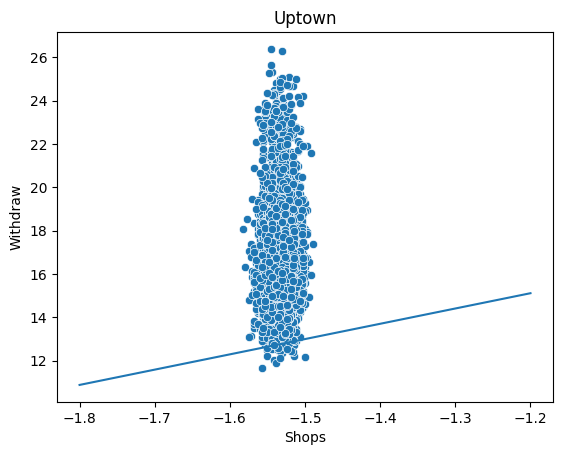

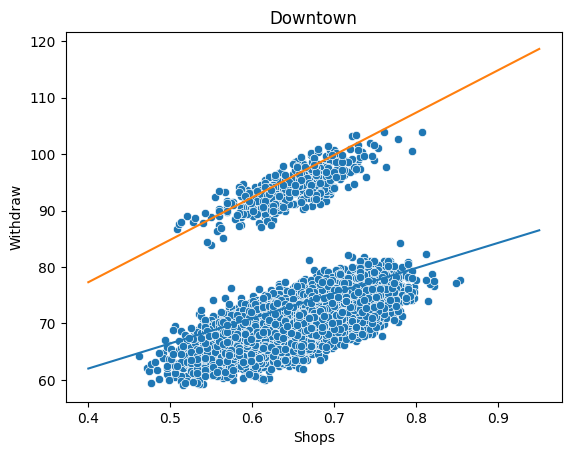

In [53]:
def uptown_reg(shops):
    return 23.576623 + 7.050417*shops

def downtown_mid_reg(shops):
    return (23.576623 + 20.638484) + (37.465296 + 7.050417)*shops

def downtown_upper_reg(shops):
    return (23.576623 + 20.638484 + 3.558970 -0.512589) + (37.465296 + 7.050417 + 30.603454)*shops

sns.scatterplot(x='Shops', y='Withdraw', data=scaled_data[scaled_data['Downtown'] == 0])
uptown_x = np.arange(-1.8,-1.2,0.05)
plt.plot(uptown_x, uptown_reg(uptown_x))
plt.title('Uptown')

plt.show()

sns.scatterplot(x='Shops', y='Withdraw', data=scaled_data[scaled_data['Downtown'] == 1])
downtown_x = np.arange(0.4,1,0.05)
plt.plot(downtown_x, downtown_mid_reg(downtown_x))
plt.plot(downtown_x, downtown_upper_reg(downtown_x))
plt.title('Downtown')
plt.show()